In [1]:
#####Context aware field factorization machines#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    return z_id

In [3]:
####データの発生####
##データの設定
k = 10
hh = 10000
item = 5000
context = 5
context_k = np.random.poisson(5.0, context); context_k[context_k <= 2] = 2
Lambda = np.random.gamma(30, 1/0.15, hh)
pt = np.random.poisson(Lambda, hh)
hhpt = np.sum(pt)
vec_k = np.repeat(1, k)

In [4]:
##IDとインデックスを設定
#IDを設定
d_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
d_list = [i for i in range(hh)]
d_vec = [i for i in range(hh)]
pt_list = [j for j in range(np.max(pt))]
context_allocation = [j for j in range(context)]
pt_n = np.repeat(0, np.max(pt))
max_n = 0
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")
    d_vec[i] = np.repeat(1, pt[i])
for j in range(np.max(pt)):
    pt_list[j] = np.array(np.where(pt_id==j)[0], dtype="int")
    pt_n[j] = pt_list[j].shape[0]
for j in range(context):
    context_allocation[j] = np.arange(context_k[j]) + max_n
    max_n = np.max(context_allocation[j]) + 1
max_index = np.array([np.max(d_list[i]) for i in range(hh)])

In [5]:
##アイテムの割当を生成
#セグメント割当を生成
topic_item = 30
phi_item = np.random.dirichlet(np.repeat(0.5, item), topic_item)
theta_item = np.random.dirichlet(np.repeat(2.5, topic_item), hh)
z_item = np.dot(np.array([np.random.multinomial(1, theta_item[i, :], 1) for i in range(hh)]).reshape(hh, topic_item), range(topic_item))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[d_list[i]] = np.dot(np.random.multinomial(1, phi_item[z_item[i], :], pt[i]), range(item))
    
#インデックスの設定
item_list = [j for j in range(item)]
item_vec = [j for j in range(item)]
item_n = np.repeat(0, item)
for j in range(item):
    item_list[j] = np.array(np.where(item_id==j)[0], dtype="int")
    item_vec[j] = np.repeat(1, len(item_list[j]))
    item_n[j] = len(item_list[j])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [6]:
##コンテキストの割当を生成
#セグメント割当を生成
topic_context = 10
theta_context = np.random.dirichlet(np.repeat(0.5, topic_context), 1).reshape(-1)
phi_context1 = np.random.dirichlet(np.repeat(2.0, context), topic_context)
phi_context2 = [np.random.dirichlet(np.repeat(0.5, context_k[j]), topic_context) for j in range(context)]
context_freq = np.random.poisson(2.25, hhpt)

#多項分布からコンテキストフラッグを生成
z_context = np.repeat(0, hhpt)
index = np.array(np.where(context_freq > 0)[0], dtype="int")
M = index.shape[0]
z_context[index] = np.dot(np.random.multinomial(1, theta_context, M), np.arange(topic_context)) + 1
context_flag = np.zeros((hhpt, context), dtype="int")
context_flag[index, ] = np.array([np.random.multinomial(context_freq[i], 
                                                        phi_context1[z_context[index[i]]-1], 1).reshape(-1) for i in range(M)])
context_flag = np.array(context_flag > 0, dtype="int")
context_freq = np.sum(context_flag, axis=1)

#多項分布からコンテキストを生成
context_id1 = np.zeros((hhpt, context), dtype="int")
context_id2 = [j for j in range(context)]
context_index = [j for j in range(context)]
context_N = np.repeat(0, context)
for j in range(context):
    context_index[j] = np.array(np.where(context_flag[:, j] > 0)[0], dtype="int")
    context_N[j] = context_index[j].shape[0]
    temp = rmnom(phi_context2[j][z_context[context_index[j]]-1, ], context_N[j], context_k[j], np.arange(context_N[j]), 0)
    context_id1[context_index[j], j] = np.array(temp, dtype="int") + 1
    context_id2[j] = np.array(temp, dtype="int")
context_id1 = context_id1 - 1
uv_index = np.array(np.where(context_freq==0)[0], dtype="int")

#インデックスの設定
context_list = [i for i in range(context)]
context_n = [i for i in range(context)]
for i in range(context):
    temp_list = [j for j in range(context_k[i])]
    temp_n = [j for j in range(context_k[i])]
    for j in range(context_k[i]):
        temp_list[j] = np.array(np.where(context_id1[context_index[i], i]==j)[0], dtype="int")
        temp_n[j] = temp_list[j].shape[0]
    context_list[i] = temp_list
    context_n[i] = temp_n

In [7]:
##階層モデルの説明変数を生成
#ユーザーの説明変数を生成
k1 = 4; k2 = 3; k3 = 4
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
column_u = u.shape[1]

#アイテムの説明変数を生成
k1 = 3; k2 = 3; k3 = 4
v1 = np.array(np.random.random(item*k1)).reshape((item, k1))
v2 = np.zeros((item, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1)
column_v = v.shape[1]

In [8]:
##応答変数が妥当な数値になるまで繰り返す
per_min = 75; per_max = 75
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##モデルパラメータを生成
    #階層モデルの分散を設定
    tau_u = np.array([0.4])
    tau_v = np.array([0.5])
    Cov_u = np.diag(np.repeat(0.15, k))
    Cov_v = np.diag(np.repeat(0.15, k))
    taut_u = tau_u.copy(); taut_v = tau_v.copy()
    Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy()

    #階層モデルの回帰係数を設定
    alpha_u1 = np.random.normal(0, 0.5, column_u)
    alpha_v1 = np.random.normal(0, 0.5, column_v)
    alpha_u2 = np.random.normal(0, 0.4, k*column_u).reshape(column_u, k)
    alpha_v2 = np.random.normal(0, 0.4, k*column_v).reshape(column_v, k)
    alphat_u1 = alpha_u1; alphat_v1 = alpha_v1
    alphat_u2 = alpha_u2; alphat_v2 = alpha_v2

    #モデルパラメータを生成
    beta = np.array([-0.75])
    beta_u = np.dot(u, alpha_u1) + np.random.normal(0, tau_u, hh)
    beta_v = np.dot(v, alpha_v1) + np.random.normal(0, tau_v, item)
    theta_u = np.array([np.random.multivariate_normal(np.dot(u[i, ], alpha_u2), Cov_u, 1).reshape(-1) for i in range(hh)])
    theta_v = np.array([np.random.multivariate_normal(np.dot(v[i, ], alpha_v2), Cov_v, 1).reshape(-1) for i in range(item)])
    theta_c = [j for j in range(context)]
    omega = np.zeros((k, k, context))
    for j in range(context):
        theta_c[j] = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(0.25, k)), context_k[j])
        omega[:, :, j] = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(0.25, k)), k)
    betat = beta.copy(); betat_u = beta_u.copy(); betat_v = beta_v.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_c = theta_c.copy(); omegat = omega.copy()
    
    ##応答変数を生成
    #モデルの期待値
    beta_mu = beta + beta_u[d_id] + beta_v[item_id]
    uv = theta_u[d_id, ] * theta_v[item_id, ]
    theta_mu = np.repeat(0.0, hhpt)
    theta_mu[uv_index] = np.dot(uv[uv_index], vec_k)
    for j in range(context):
        index = context_index[j]
        theta_mu[index] += np.dot(np.dot(uv[index, ], omega[:, :, j]) * theta_c[j][context_id2[j], ], vec_k)
    logit = beta_mu + theta_mu
    logit_t = logit.copy()
    
    #ベルヌーイ分布から応答変数を生成
    Prob = np.exp(logit) / (1 + np.exp(logit))
    y = np.random.binomial(1, Prob, hhpt)
    y_vec = y[:, np.newaxis]

    #break条件
    if (np.mean(y) > 0.25) & (np.mean(y) < 0.4):
        break

1
2


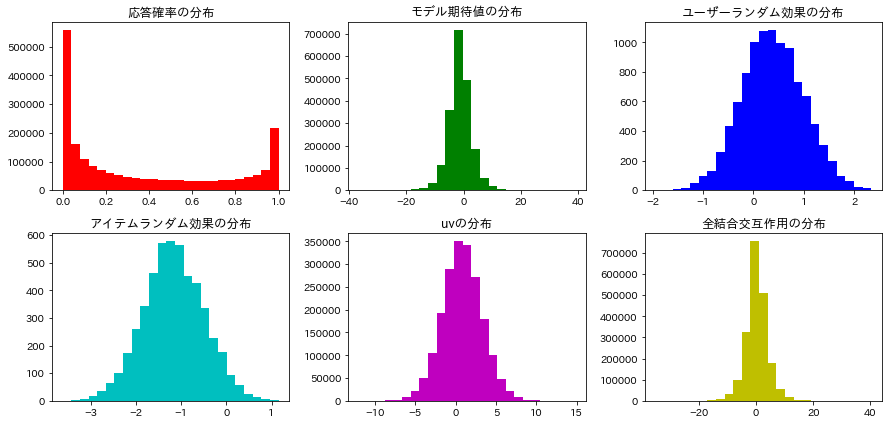

In [9]:
#潜在変数ごとのヒストグラム
uv_vec = np.sum(uv, axis=1)
dt = [Prob, logit, beta_u, beta_v, uv_vec, theta_mu]
fig_range = np.append(np.array([0, np.min(logit), np.min(beta_u), np.min(beta_v), np.min(uv_vec), np.min(theta_mu)]), 
                      np.array([1.0, np.max(logit), np.max(beta_u), np.max(beta_v), np.max(uv_vec), np.max(theta_mu)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["応答確率の分布", "モデル期待値の分布", "ユーザーランダム効果の分布", "アイテムランダム効果の分布",
          "uvの分布", "全結合交互作用の分布"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [10]:
####テストデータの作成####
##データの設定
shrink = 1.5
pt0 = np.random.poisson(Lambda/shrink, hh)
N = np.sum(pt0)

In [11]:
##IDとインデックスを設定
#IDを設定
d_id0 = np.repeat(range(hh), pt0)
pt_id0 = np.array(list(itertools.chain(*[np.array(range(pt0[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
d_list0 = [i for i in range(hh)]
d_vec0 = [i for i in range(hh)]
pt_list0 = [j for j in range(np.max(pt0))]
pt_n0 = np.repeat(0, np.max(pt0))
for i in range(hh):
    d_list0[i] = np.array(np.where(d_id0==i)[0], dtype="int")
    d_vec0[i] = np.repeat(1, pt0[i])
for j in range(np.max(pt0)):
    pt_list0[j] = np.array(np.where(pt_id0==j)[0], dtype="int")
    pt_n0[j] = pt_list0[j].shape[0]

In [12]:
##アイテムの割当を生成
#多項分布からアイテムを生成
item_id0 = np.zeros(N, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id0[d_list0[i]] = np.dot(np.random.multinomial(1, phi_item[z_context[i], :], pt0[i]), range(item))
    
#インデックスの設定
item_list0 = [j for j in range(item)]
item_vec0 = [j for j in range(item)]
item_n0 = np.repeat(0, item)
for j in range(item):
    item_list0[j] = np.array(np.where(item_id0==j)[0], dtype="int")
    item_vec0[j] = np.repeat(1, len(item_list0[j]))
    item_n0[j] = len(item_list0[j])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [13]:
##コンテキストの割当を生成
#多項分布からコンテキストフラッグを生成
context_freq0 = np.random.poisson(2.25, N)
z_context0 = np.repeat(0, N)
index0 = np.array(np.where(context_freq0 > 0)[0], dtype="int")
M0 = index0.shape[0]
z_context0[index0] = np.dot(np.random.multinomial(1, theta_context, M0), np.arange(topic_context)) + 1
context_flag0 = np.zeros((N, context), dtype="int")
context_flag0[index0, ] = np.array([np.random.multinomial(context_freq0[i], 
                                                          phi_context1[z_context0[index0[i]]-1], 1).reshape(-1) for i in range(M0)])
context_flag0 = np.array(context_flag0 > 0, dtype="int")
context_freq0 = np.sum(context_flag0, axis=1)

#多項分布からコンテキストを生成
context_id01 = np.zeros((N, context), dtype="int")
context_id02 = [j for j in range(context)]
context_index0 = [j for j in range(context)]
context_N0 = np.repeat(0, context)
for j in range(context):
    context_index0[j] = np.array(np.where(context_flag0[:, j] > 0)[0], dtype="int")
    context_N0[j] = context_index0[j].shape[0]
    temp = rmnom(phi_context2[j][z_context0[context_index0[j]]-1, ], context_N0[j], context_k[j], np.arange(context_N0[j]), 0)
    context_id01[context_index0[j], j] = np.array(temp, dtype="int") + 1
    context_id02[j] = np.array(temp, dtype="int")
context_id01 = context_id01 - 1
uv_index0 = np.array(np.where(context_freq0==0)[0], dtype="int")

In [14]:
##応答変数を生成
#モデルの期待値
beta_mu = betat + betat_u[d_id0] + betat_v[item_id0]
uv = thetat_u[d_id0, ] * thetat_v[item_id0, ]
theta_mu = np.repeat(0.0, N)
theta_mu[uv_index0] = np.dot(uv[uv_index0, ], vec_k)
for j in range(context):
    index = context_index0[j]
    theta_mu[index] += np.dot(np.dot(uv[index, ], omegat[:, :, j]) * thetat_c[j][context_id02[j], ], vec_k)
logit = beta_mu + theta_mu
logit_t0 = logit.copy()

#ベルヌーイ分布から応答変数を生成
Prob = np.exp(logit) / (1 + np.exp(logit))
y0 = np.random.binomial(1, Prob, N)
y_vec0 = y0[:, np.newaxis]

In [15]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##HMCでパラメータを推定するための関数
#対数事後分布の和を計算する関数
def Posterior(y, mu, theta, alpha_mu, inv_Cov, index, n, k, pattern1, pattern2):
    #ロジットモデルの対数尤度
    logit_exp = np.exp(mu)   #ロジットの期待値の指数
    Prob = logit_exp / (1 + logit_exp)
    Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -25)
    LLho = y*np.log(Prob) + (1-y)*np.log(1-Prob)

    #多変量正規分布の対数事前分布
    er = theta - alpha_mu   #パラメータの誤差
    if pattern1==1:
        LLi_mvn = -1/2 * np.dot(np.dot(er, inv_Cov) * er, np.repeat(1, k))
    else:
        LLi_mvn = -1/2 * er * inv_Cov * er 

    #対数事後分布の和
    if pattern2==1:
        LL = np.repeat(0.0, n)
        for i in range(n):
            LL[i] = np.sum(LLho[index[i], ]) + LLi_mvn[i]
    else:
        LL = np.sum(LLho) + LLi_mvn
    return LL, LLho

In [16]:
#期待値パラメータの勾配を計算する関数
def dloglike(beta, beta_mu, theta_mu, tau, y):
    #応答確率の定義
    logit_exp = np.exp(beta + beta_mu + theta_mu)
    Prob = logit_exp / (1 + logit_exp)

    #対数事後分布の微分関数の和
    dlogit = y - Prob
    dnorm = -beta / tau
    dlogit_sums = np.sum(dlogit) + dnorm
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, beta_mu, theta_mu, tau, y) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, beta_mu, theta_mu, tau, y) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [17]:
#ユーザーパラメータの事後分布の勾配ベクトルを計算する関数
def dloglike_u(theta, beta_item, theta_item, RA, alpha_mu, inv_Cov, y, y_vec, hh, d_id, d_list, hhpt, k, vec_k):
    #パラメータの設定
    beta_u = theta[:, 0]
    theta_u = theta[:, 1:]

    #モデルの期待値と応答確率の定義
    beta_mu = beta_u[d_id] + beta_item
    theta_mu = np.dot(theta_u[d_id, ] * theta_item * RA, vec_k)
    logit_exp = np.exp(beta + beta_mu + theta_mu)
    Prob = logit_exp / (1 + logit_exp)

    #微分関数の設定
    er = theta - alpha_mu   #パラメータの誤差
    x = np.hstack((np.repeat(1, hhpt)[:, np.newaxis], theta_item * RA))   #期待値の勾配
    dlogit = y_vec*x - Prob[:, np.newaxis]*x
    dmvn = -np.dot(inv_Cov, er.T).T

    #対数事後分布の勾配ベクトルの和
    dlogit_sums = np.zeros((hh, k+1))
    for i in range(hh):
        dlogit_sums[i, ] = np.sum(dlogit[d_list[i], ], axis=0) + dmvn[i, ]
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_u(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, beta_item, theta_item, RA, alpha_mu, inv_Cov, y, y_vec, hh, d_id, d_list, hhpt, k, vec_k) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, beta_item, theta_item, RA, alpha_mu, inv_Cov, y, y_vec, hh, d_id, d_list, hhpt, k, vec_k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [18]:
#アイテムパラメータの事後分布の勾配ベクトルを計算する関数
def dloglike_v(theta, beta_user, theta_user, RA, alpha_mu, inv_Cov, y, y_vec, item, item_id, item_list, hhpt, k, vec_k):
    #パラメータの設定
    beta_v = theta[:, 0]
    theta_v = theta[:, 1:]

    #モデルの期待値と応答確率の定義
    beta_mu = beta_user + beta_v[item_id]
    theta_mu = np.dot(theta_user * theta_v[item_id, ] * RA, vec_k)
    logit_exp = np.exp(beta + beta_mu + theta_mu)
    Prob = logit_exp / (1 + logit_exp)

    #微分関数の設定
    er = theta - alpha_mu   #パラメータの誤差
    x = np.hstack((np.repeat(1, hhpt)[:, np.newaxis], theta_user * RA))   #期待値の勾配
    dlogit = y_vec*x - Prob[:, np.newaxis]*x
    dmvn = -np.dot(inv_Cov, er.T).T

    #対数事後分布の勾配ベクトルの和
    dlogit_sums = np.zeros((item, k+1))
    for i in range(item):
        dlogit_sums[i, ] = np.sum(dlogit[item_list[i], ], axis=0) + dmvn[i, ]
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_v(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, beta_user, theta_user, RA, alpha_mu, inv_Cov, y, y_vec, item, item_id, item_list, hhpt, k, vec_k) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, beta_user, theta_user, RA, alpha_mu, inv_Cov, y, y_vec, item, item_id, item_list, hhpt, k, vec_k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [19]:
#コンテキストパラメータの事後分布の勾配ベクトルを計算する関数
def dloglike_c(theta, theta_c, beta, beta_mu, uv, theta_uv, theta_field, inv_Cov_c, y, y_vec, fd, context_k, context_index,
              context_list, context_id2, uv_index, k, vec_k):
    #パラメータの設定
    theta_c[fd] = theta.copy()

    #モデル期待値と応答確率の定義
    theta_mu = np.sum(theta_field[:, np.delete(np.arange(context), fd)], axis=1)
    theta_mu[uv_index] = np.dot(uv[uv_index, ], vec_k)
    theta_mu[context_index[fd]] += np.dot(theta_uv[fd] * theta[context_id2[fd], ], vec_k)
    logit_exp = np.exp(beta + beta_mu + theta_mu)
    Prob = logit_exp / (1 + logit_exp)

    #微分関数の設定
    index = context_index[fd]
    dmvn = -np.dot(inv_Cov_c, theta.T).T
    dlogit = y_vec[index, ]*theta_uv[fd] - Prob[index][:, np.newaxis]*theta_uv[fd]

    #勾配ベクトルの和
    dlogit_sums = np.zeros((context_k[fd], k))
    for j in range(context_k[fd]):
        dlogit_sums[j, ] = np.sum(dlogit[context_list[fd][j], ], axis=0) + dmvn[j, ]
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_c(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, theta_c, beta, beta_mu, uv, theta_uv, theta_field, inv_Cov_c, y, y_vec, fd, context_k, context_index,
                       context_list, context_id2, uv_index, k, vec_k) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, theta_c, beta, beta_mu, uv, theta_uv, theta_field, inv_Cov_c, y, y_vec, fd, context_k, context_index,
                       context_list, context_id2, uv_index, k, vec_k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [20]:
#対数事後分布の和を計算する関数
def Posterior_g(logit, theta, y, inv_Cov_g):
    #ロジットモデルの対数尤度
    logit_exp = np.exp(logit)
    Prob = logit_exp / (1 + logit_exp)
    Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -25)
    LLho = y*np.log(Prob) + (1-y)*np.log(1-Prob)

    #多変量正規分布の対数事前分布
    LLi_mvn = -1/2 * np.dot(np.dot(theta.reshape(-1), inv_Cov_g), theta.reshape(-1))

    #対数事後分布の和
    LL = np.sum(LLho) + LLi_mvn
    return(LL)

#omegaの事後分布の勾配ベクトルを計算する関数
def dloglike_g(theta, theta_c, RAR, beta, beta_mu, uv, alpha_g, inv_Cov_g, y, y_vec, x, fd, context_id2, context_index, vec_k):
    #モデルの期待値と応答確率の定義
    omega = theta.reshape(k, k)
    index = context_index[fd]
    RAR[index, ] += np.dot(theta_c[fd][context_id2[fd], ], omega.T)
    theta_mu = np.dot(uv * RAR, vec_k)
    logit_exp = np.exp(beta + beta_mu + theta_mu)
    Prob = logit_exp / (1 + logit_exp)
    Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -25)
    
    #勾配ベクトルの和
    dmvn = -np.dot(inv_Cov_g, theta.reshape(-1)).T
    dlogit = np.sum(y_vec[index, ]*x - Prob[index, np.newaxis]*x, axis=0)
    dlogit_sums = -(dlogit + dmvn)
    return dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_g(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, theta_c, RAR, beta, beta_mu, uv, alpha_g, inv_Cov_g, y, y_vec, x_list[fd],
                       fd, context_id2, context_index, vec_k) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, theta_c, RAR, beta, beta_mu, uv, alpha_g, inv_Cov_g, y, y_vec, x_list[fd],
                        fd, context_id2, context_index, vec_k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [21]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [22]:
##アルゴリズムの設定
R = 2000
keep = 10
burnin = int(100/keep)
iter = 0
disp = 10
e1 = 0.001
e2 = 0.05
e3 = 0.005
L1 = 3
L2 = 1

In [23]:
##事前分布の設定
#階層モデルの事前分布
delta = np.repeat(0, k)
ADelta_u = np.diag(np.repeat(0.1, column_u))
Deltabar_u = np.full((column_u, k+1), 0.0)
ADelta_v = np.diag(np.repeat(0.1, column_v))
Deltabar_v = np.full((column_v, k+1), 0.0)
nu = 1
V = 0.1 * np.diag(np.ones(k+1))
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
alpha_c = np.repeat(0, k)
alpha_g = np.repeat(0, k*k)
Cov_c = np.diag(np.repeat(100.0, k)); inv_Cov_c = np.linalg.inv(Cov_c)
Cov_g = np.diag(np.repeat(100.0, k*k)); inv_Cov_g = np.linalg.inv(Cov_g)
tau = 100 
s02 = 1.0
v02 = 1.0

In [24]:
##モデルパラメータの真値
#階層モデルの分散の真値
tau_u = taut_u.copy(); inv_tau_u = 1/tau_u
tau_v = taut_v.copy(); inv_tau_v = 1/tau_v
Cov_u = Covt_u.copy(); inv_Cov_u = np.linalg.inv(Cov_u)
Cov_v = Covt_v.copy(); inv_Cov_v = np.linalg.inv(Cov_v)

#階層モデルの回帰係数の真値
alpha_u1 = alphat_u1.copy(); u_mu1 = np.dot(u, alpha_u1)
alpha_v1 = alphat_v1.copy(); v_mu1 = np.dot(v, alpha_v1)
alpha_u2 = alphat_u2.copy(); u_mu2 = np.dot(u, alpha_u2)
alpha_v2 = alphat_v2.copy(); v_mu2 = np.dot(v, alpha_v2)

#モデルパラメータの真値
beta = betat.copy()
beta_u = betat_u.copy()
beta_v = betat_v.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_c = thetat_c.copy()
omega = omegat.copy()
omega = np.zeros((k, k, context))
for j in range(context):
    omega[:, :, j] = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(0.2, k)), k)
    
#モデルパラメータとデータを結合
beta_user = beta_u[d_id]
beta_item = beta_v[item_id]
theta_user = theta_u[d_id, ]
theta_item = theta_v[item_id, ]
theta_context = [j for j in range(context)]
RA = np.zeros((hhpt, k)); RA[uv_index, ] = 1.0
for j in range(context):
    index = context_index[j]
    theta_context[j] = theta_c[j][context_id2[j], ]
    RA[index, ] += np.dot(theta_context[j], omega[:, :, j].T)

#モデルの期待値
beta_mu = beta_user + beta_item
uv = theta_user * theta_item
theta_mu = np.dot(uv * RA, vec_k)
logit = betat + beta_mu + theta_mu

In [25]:
##初期値の設定
#階層モデルの分散の初期値
tau_u = np.array([0.5]); inv_tau_u = 1/tau_u
tau_v = np.array([0.5]); inv_tau_v = 1/tau_v
Cov_u = np.diag(np.repeat(0.5, k)); inv_Cov_u = np.linalg.inv(Cov_u)
Cov_v = np.diag(np.repeat(0.5, k)); inv_Cov_v = np.linalg.inv(Cov_v)

#階層モデルの回帰係数の初期値
alpha_u1 = np.random.normal(0, 0.2, column_u)
alpha_v1 = np.random.normal(0, 0.2, column_v)
alpha_u2 = np.random.normal(0, 0.2, k*column_u).reshape(column_u, k)
alpha_v2 = np.random.normal(0, 0.2, k*column_v).reshape(column_v, k)
u_mu1 = np.dot(u, alpha_u1)
v_mu1 = np.dot(v, alpha_v1)
u_mu2 = np.dot(u, alpha_u2)
v_mu2 = np.dot(v, alpha_v2)

#モデルパラメータの初期値
beta_u = np.random.normal(0, 0.5, hh)
beta_v = np.random.normal(0, 0.5, item)
theta_u = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(0.2, k)), hh)
theta_v = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(0.2, k)), item)
theta_c = [j for j in range(context)]
omega = np.zeros((k, k, context))
for j in range(context):
    theta_c[j] = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(0.2, k)), context_k[j])
    omega[:, :, j] = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(0.2, k)), k)
    
#モデルパラメータとデータを結合
beta_user = beta_u[d_id]
beta_item = beta_v[item_id]
theta_user = theta_u[d_id, ]
theta_item = theta_v[item_id, ]
theta_context = [j for j in range(context)]
RA = np.zeros((hhpt, k)); RA[uv_index, ] = 1.0
for j in range(context):
    index = context_index[j]
    theta_context[j] = theta_c[j][context_id2[j], ]
    RA[index, ] += np.dot(theta_context[j], omega[:, :, j].T)

#モデルの期待値
beta_mu = beta_user + beta_item
uv = theta_user * theta_item
theta_mu = np.dot(uv * RA, vec_k)
logit = beta + beta_mu + theta_mu
Prob = np.exp(logit) / (1 + np.exp(logit))
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -25)

In [26]:
##サンプリング結果の格納用配列
#階層モデルのパラメータの格納用配列
ALPHA_U1 = np.zeros((int(R/keep), column_u))
ALPHA_U2 = np.zeros((column_u, k, int(R/keep)))
ALPHA_V1 = np.zeros((int(R/keep), column_v))
ALPHA_V2 = np.zeros((column_v, k, int(R/keep)))
TAU_U = np.repeat(0.0, int(R/keep))
COV_U = np.zeros((k, k, int(R/keep)))
TAU_V = np.repeat(0.0, int(R/keep))
COV_V = np.zeros((k, k, int(R/keep)))

#モデルパラメータの格納用配列
BETA = np.repeat(0.0, int(R/keep))
BETA_U = np.zeros((int(R/keep), hh))
BETA_V = np.zeros((int(R/keep), item))
THETA_U = np.zeros((hh, k, int(R/keep)))
THETA_V = np.zeros((item, k, int(R/keep)))
THETA_C = [i for i in range(int(R/keep))]
OMEGA = np.zeros((k, k, context, int(R/keep)))

In [27]:
##データとインデックスの設定
#階層モデルの定数
uu = np.dot(u.T, u)
inv_uu = np.linalg.inv(np.dot(u.T, u) + ADelta_u)
vv = np.dot(v.T, v)
inv_vv = np.linalg.inv(np.dot(v.T, v) + ADelta_v)

#インデックスの設定
new_vec = np.append(1, vec_k)
allocation_index1 = np.repeat(np.arange(k), k)
allocation_index2 = np.tile(np.arange(k), k)

In [28]:
##対数尤度の基準値
#学習データに対する1パラメータモデルの対数尤度
mu = np.mean(y)
LLst = np.sum(y*np.log(mu) + (1-y)*np.log(1-mu))
print(LLst)

#テストデータに対する1パラメータモデルの対数尤度
mu = np.mean(y)
LLst0 = np.sum(y0*np.log(mu) + (1-y0)*np.log(1-mu))
print(LLst0)

#学習データに対する真値での対数尤度
beta_mu0 = betat_u[d_id] + betat_v[item_id]
uv0 = thetat_u[d_id, ] * thetat_v[item_id, ]
RA0 = np.zeros((hhpt, k)); RA0[uv_index, ] = 1.0
for j in range(context):
    RA0[context_index[j], ] += np.dot(thetat_c[j][context_id2[j], ], omegat[:, :, j].T)
theta_mu0 = np.dot(uv0 * RA0, vec_k)
logit0 = betat + beta_mu0 + theta_mu0
Prob = np.exp(logit0) / (1 + np.exp(logit0))
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -25)
LLbest = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))
print(LLbest)

#テストデータに対する真値での対数尤度
beta_mu0 = betat_u[d_id0] + betat_v[item_id0]
uv0 = thetat_u[d_id0, ] * thetat_v[item_id0, ]
RA0 = np.zeros((N, k)); RA0[uv_index0, ] = 1.0
for j in range(context):
    RA0[context_index0[j], ] += np.dot(thetat_c[j][context_id02[j], ], omegat[:, :, j].T)
theta_mu0 = np.dot(uv0 * RA0, vec_k)
logit0 = betat + beta_mu0 + theta_mu0
Prob = np.exp(logit0) / (1 + np.exp(logit0))
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -25)
LLbest0 = np.sum(y0*np.log(Prob) + (1-y0)*np.log(1-Prob))
print(LLbest0)

-1310280.3704474666
-876244.5417202291
-617876.6079447905
-414687.0987433486


In [ ]:
####ハミルトニアンモンテカルロ法でパラメータをサンプリング####
for rp in range(R):
    
    ##期待値パラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.normal(0, 1, 1)
    betad = beta.copy()

    #リープフロッグ法による1ステップ移動
    res = leapfrog(rold, betad, dloglike, e1, L1)
    rnew = res[0]
    betan = res[1]

    #移動前と移動後のハミルトニアン
    logit_new = betan + beta_mu + theta_mu   #期待値を更新
    Hnew = -Posterior(y, logit_new, betan, 0, 1/tau, d_list, hh, 1, 0, 0)[0] + np.power(rnew, 2)/2
    Hold = -Posterior(y, logit, betad, 0, 1/tau, d_list, hh, 1, 0, 0)[0] + np.power(rold, 2)/2

    #新しいパラメータを採択
    rand = np.random.uniform(0, 1, 1)
    alpha = np.min(np.append(1, np.exp(Hold - Hnew)))
    alpha1 = alpha.copy()

    #alphaの値に基づき新しいbetaを採択
    flag = np.array((alpha > rand), dtype="int")
    beta = flag*betan + (1-flag)*betad
    if flag==1:
        logit = logit_new.copy()
    
    
    ##ユーザーパラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.multivariate_normal(np.repeat(0, k+1), np.diag(np.repeat(1, k+1)), hh)
    thetad = np.hstack((beta_u[:, np.newaxis], theta_u))

    #事前分布を結合
    alpha_mu = np.hstack((u_mu1[:, np.newaxis], u_mu2))
    inv_Cov = np.diag(np.append(inv_tau_u, np.diag(inv_Cov_u)))

    #リープフロッグ法による1ステップ移動
    res = leapfrog_u(rold, thetad, dloglike_u, e2, L1)
    rnew = res[0]
    thetan = res[1]

    #サンプリングされたパラメータの期待値を更新
    beta_mu = thetan[d_id, 0] + beta_item
    theta_mu = np.dot(thetan[:, 1:][d_id, ] * theta_item * RA, vec_k)
    logit_new = beta + beta_mu + theta_mu   #期待値を更新

    #移動前と移動後のハミルトニアン
    Hnew = -Posterior(y, logit_new, thetan, alpha_mu, inv_Cov, d_list, hh, k+1, 1, 1)[0] + np.dot(np.power(rnew, 2), new_vec)/2
    Hold = -Posterior(y, logit, thetad, alpha_mu, inv_Cov, d_list, hh, k+1, 1, 1)[0] + np.dot(np.power(rold, 2), new_vec)/2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, hh)
    alpha = np.min(np.hstack((np.repeat(1, hh)[:, np.newaxis], np.exp(Hold - Hnew)[:, np.newaxis])), axis=1)
    alpha2 = alpha.copy()

    #alphaの値に基づき新しいユーザーパラメータを採択
    flag = np.array(alpha > rand, dtype="int")[:, np.newaxis]
    theta_temp = flag*thetan + (1-flag)*thetad
    beta_u = theta_temp[:, 0]; theta_u = theta_temp[:, 1:]
    
    #パラメータと期待値の更新
    beta_user = beta_u[d_id]; theta_user = theta_u[d_id, ]
    beta_mu = beta_user + beta_item
    uv = np.dot(theta_user * theta_item, vec_k)
    theta_mu = np.dot(theta_user * theta_item * RA, vec_k)
    logit = beta + beta_mu + theta_mu
    
    
    ##アイテムパラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.multivariate_normal(np.repeat(0, k+1), np.diag(np.repeat(1, k+1)), item)
    thetad = np.hstack((beta_v[:, np.newaxis], theta_v))

    #事前分布を結合
    alpha_mu = np.hstack((v_mu1[:, np.newaxis], v_mu2))
    inv_Cov = np.diag(np.append(inv_tau_v, np.diag(inv_Cov_v)))

    #リープフロッグ法による1ステップ移動
    res = leapfrog_v(rold, thetad, dloglike_v, e2, L1)
    rnew = res[0]
    thetan = res[1]    

    #サンプリングされたパラメータの期待値を更新
    beta_mu = beta_user + thetan[item_id, 0]
    theta_mu = np.dot(theta_user * thetan[:, 1:][item_id, ] * RA, vec_k)
    logit_new = beta + beta_mu + theta_mu   #期待値を更新

    #移動前と移動後のハミルトニアン
    new_vec = np.append(1, vec_k)
    Hnew = -Posterior(y, logit_new, thetan, alpha_mu, inv_Cov, item_list, item, k+1, 1, 1)[0] + np.dot(np.power(rnew, 2), new_vec)/2
    Hold = -Posterior(y, logit, thetad, alpha_mu, inv_Cov, item_list, item, k+1, 1, 1)[0] + np.dot(np.power(rold, 2), new_vec)/2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, item)
    alpha = np.min(np.hstack((np.repeat(1, item)[:, np.newaxis], np.exp(Hold - Hnew)[:, np.newaxis])), axis=1)
    alpha3 = alpha.copy()

    #alphaの値に基づき新しいユーザーパラメータを採択
    flag = np.array(alpha > rand, dtype="int")[:, np.newaxis]
    theta_temp = flag*thetan + (1-flag)*thetad
    beta_v = theta_temp[:, 0]; theta_v = theta_temp[:, 1:]
    
    #パラメータと期待値の更新
    beta_item = beta_v[item_id]; theta_item = theta_v[item_id, ]
    beta_mu = beta_user + beta_item
    uv = theta_user * theta_item
    theta_mu = np.dot(uv * RA, vec_k)
    logit = beta + beta_mu + theta_mu
    
    
    ##コンテキストパラメータをサンプリング
    #パラメータの定数を更新
    theta_uv = [j for j in range(context)]
    theta_field = np.zeros((hhpt, context))
    for j in range(context):
        index = context_index[j]
        theta_uv[j] = np.dot(uv[index, ], omega[:, :, j])
        theta_field[index, j] = np.dot(theta_uv[j] * theta_c[j][context_id2[j], ], vec_k)

    #コンテキストごとにHMCによりサンプリング
    alpha4 = [j for j in range(context)]
    for fd in range(context):
        
        #HMCの新しいパラメータを生成
        rold = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.repeat(1.0, k)), context_k[fd])
        thetad = theta_c[fd].copy()

        #リープフロッグ法による1ステップ移動
        res = leapfrog_c(rold, thetad, dloglike_c, e3, L2)
        rnew = res[0]
        thetan = res[1]

        #サンプリングされたパラメータの期待値を更新
        theta_mu = np.sum(theta_field[:, np.delete(np.arange(context), fd)], axis=1)
        theta_mu[uv_index] = np.dot(uv[uv_index, ], vec_k)
        theta_mu[context_index[fd]] += np.dot(theta_uv[fd] * thetan[context_id2[fd], ], vec_k)
        logit_new = beta + beta_mu + theta_mu

        #移動前と移動後のハミルトニアン
        index0 = context_list[fd]; context0 = context_k[fd]
        Hnew = -Posterior(y, logit_new, thetan, alpha_c, inv_Cov_c, index0, context0, k, 1, 1)[0]
        Hold = -Posterior(y, logit, thetad, alpha_c, inv_Cov_c, index0, context0, k, 1, 1)[0]

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, context0)
        alpha = np.min(np.hstack((np.repeat(1, context0)[:, np.newaxis], np.exp(Hold - Hnew)[:, np.newaxis])), axis=1)
        alpha4[fd] = alpha.copy()

        #alphaの値に基づき新しいユーザーパラメータを採択
        flag = np.array(alpha > rand, dtype="int")[:, np.newaxis]
        theta_c[fd] = flag*thetan + (1-flag)*thetad

        #期待値を更新
        theta_field[context_index[fd], fd] = np.dot(theta_uv[fd] * theta_c[fd][context_id2[fd], ], vec_k)
        theta_mu = np.sum(theta_field[:, np.delete(np.arange(context), fd)], axis=1)
        theta_mu[uv_index] = np.dot(uv[uv_index, ], vec_k)
        theta_mu[context_index[fd]] += np.dot(theta_uv[fd] * theta_c[fd][context_id2[fd], ], vec_k)
        logit = beta + beta_mu + theta_mu
        
    #パラメータを更新
    RA = np.zeros((hhpt, k)); RA[uv_index, ] = 1.0
    for j in range(context):
        index = context_index[j]
        theta_context[j] = theta_c[j][context_id2[j], ]
        RA[index, ] += np.dot(theta_context[j], omega[:, :, j].T)
    
        
    ##双線形回帰行列をサンプリング
    #omegaの期待値の勾配を定義
    x_list = [j for j in range(context)]
    for j in range(context):
        index = context_index[j]
        temp_uv = uv[index, ]
        temp_theta = theta_c[j][context_id2[j], ]
        x_list[j] = temp_uv[:, allocation_index1] * temp_theta[:, allocation_index2]

    #コンテキストごとにHMCによりサンプリング
    alpha5 = np.repeat(0.0, context)
    for fd in range(context):
        
        #HMCの新しいパラメータを生成
        rold = np.random.multivariate_normal(np.repeat(0, k*k), np.diag(np.repeat(1.0, k*k)), 1).reshape(-1)
        thetad = omega[:, :, fd].reshape(-1)
        logit_old = logit.copy()
        RA_old = RA.copy()
        theta_old = theta_mu.copy()

        #リープフロッグ法による1ステップ移動
        RA[context_index[fd], ] -= np.dot(theta_c[fd][context_id2[fd], ], thetad.reshape(k, k).T); RAR = RA.copy()
        res = leapfrog_g(rold, thetad, dloglike_g, e3, L2)
        rnew = res[0]
        thetan = res[1].reshape(k, k)

        #サンプリングされたパラメータの期待値を更新
        RA[context_index[fd], ] += np.dot(theta_c[fd][context_id2[fd], ], thetan.reshape(k, k).T)
        theta_mu = np.dot(uv * RA, vec_k)
        logit_new = beta + beta_mu + theta_mu

        #移動前と移動後のハミルトニアン
        Hnew = -Posterior_g(logit_new, thetan, y, inv_Cov_g)
        Hold = -Posterior_g(logit, thetad, y, inv_Cov_g)

        #新しいパラメータを採択
        rand = np.random.uniform(0, 1, 1)
        alpha = np.min(np.append(1, np.exp(Hold - Hnew)))
        alpha5[fd] = alpha.copy()

        #alphaの値に基づき新しいbetaを採択
        flag = np.array((alpha > rand), dtype="int")
        temp_omega = flag*thetan + (1-flag)*thetad.reshape(k, k)
        omega[:, :, fd] = temp_omega.reshape(k, k)
        if flag==1:
            logit = logit_new.copy()
        else:
            RA = RA_old.copy()
            logit = logit_old.copy()
            theta_mu = theta_old.copy()
            
    
    ##階層モデルのパラメータをサンプリング
    #多変量回帰モデルからユーザーパラメータをサンプリング
    theta = np.hstack((beta_u[:, np.newaxis], theta_u))
    Cov = np.diag(np.append(tau_u, np.diag(Cov_u)))
    out = rmultireg(theta, u, inv_uu, np.dot(u.T, theta), Cov, ADelta_u, Deltabar_u, V, nu, hh, column_u, k+1)
    alpha_u1 = out[0][:, 0]; alpha_u2 = out[0][:, 1:]
    tau_u = np.diag(out[1])[0]; Cov_u = np.diag(np.diag(out[1])[1:])
    u_mu1 = np.dot(u, alpha_u1)
    u_mu2 = np.dot(u, alpha_u2)
    inv_tau_u = 1/tau_u
    inv_Cov_u = np.linalg.inv(Cov_u)

    #多変量回帰モデルからアイテムのパラメータをサンプリング
    theta = np.hstack((beta_v[:, np.newaxis], theta_v))
    Cov = np.diag(np.append(tau_v, np.diag(Cov_v)))
    out = rmultireg(theta, v, inv_vv, np.dot(v.T, theta), Cov, ADelta_v, Deltabar_v, V, nu, item, column_v, k+1)
    alpha_v1 = out[0][:, 0]; alpha_v2 = out[0][:, 1:]
    tau_v = np.diag(out[1])[0]; Cov_v = np.diag(np.diag(out[1])[1:])
    v_mu1 = np.dot(v, alpha_v1)
    v_mu2 = np.dot(v, alpha_v2)
    inv_tau_v = 1/tau_v
    inv_Cov_v = np.linalg.inv(Cov_v)
    
    
    ##サンプリング結果の格納と表示
    if rp%keep==0:
        #サンプリング結果の格納
        mkeep = int(rp/keep)
        ALPHA_U1[mkeep, ] = alpha_u1
        ALPHA_U2[:, :, mkeep] = alpha_u2
        ALPHA_V1[mkeep, ] = alpha_v1
        ALPHA_V2[:, :, mkeep] = alpha_v2
        TAU_U[mkeep] = tau_u
        COV_U[:, :, mkeep] = Cov_u
        TAU_V[mkeep] = tau_v
        COV_V[:, :, mkeep] = Cov_v
        BETA[mkeep] = beta
        BETA_U[mkeep, ] = beta_u
        BETA_V[mkeep, ] = beta_v
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_C[mkeep] = theta_c
        OMEGA[:, :, :, mkeep] = omega
        
        #学習データに対する対数尤度を更新
        Prob = np.exp(logit) / (1 + np.exp(logit))
        Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -25)
        LL = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))

        #テストデータに対する真値での対数尤度
        beta_mu0 = beta_u[d_id0] + beta_v[item_id0]
        uv0 = theta_u[d_id0, ] * theta_v[item_id0, ]
        RA0 = np.zeros((N, k)); RA0[uv_index0, ] = 1.0
        for j in range(context):
            RA0[context_index0[j], ] += np.dot(theta_c[j][context_id02[j], ], omega[:, :, j].T)
        theta_mu0 = np.dot(uv0 * RA0, vec_k)
        logit0 = beta + beta_mu0 + theta_mu0
        Prob = np.exp(logit0) / (1 + np.exp(logit0))
        Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -25)
        LL0 = np.sum(y0*np.log(Prob) + (1-y0)*np.log(1-Prob))
        
        #サンプリング結果の表示
        print(rp)
        print([np.round(np.mean(alpha2), 3), np.round(np.mean(alpha3), 3), np.round(np.mean(alpha5), 3)])
        print([np.round(LL, 1), np.round(LLbest, 1), np.round(LLst, 1)])
        print([np.round(LL0, 1), np.round(LLbest0, 1), np.round(LLst0, 1)])

0
[0.998, 0.998, 1.0]
[-1296414.9, -617876.6, -1310280.4]
[-883173.4, -414687.1, -876244.5]
10
[0.989, 0.979, 0.679]
[-1219206.7, -617876.6, -1310280.4]
[-842150.0, -414687.1, -876244.5]
20
[0.98, 0.971, 1.0]
[-923284.9, -617876.6, -1310280.4]
[-651893.0, -414687.1, -876244.5]
30
[0.972, 0.966, 1.0]
[-881905.1, -617876.6, -1310280.4]
[-627824.7, -414687.1, -876244.5]
40
[0.969, 0.964, 1.0]
[-820330.2, -617876.6, -1310280.4]
[-591852.3, -414687.1, -876244.5]
50
[0.965, 0.96, 1.0]
[-785418.9, -617876.6, -1310280.4]
[-572667.0, -414687.1, -876244.5]
60
[0.964, 0.96, 1.0]
[-765350.9, -617876.6, -1310280.4]
[-563489.2, -414687.1, -876244.5]
70
[0.964, 0.957, 1.0]
[-754163.5, -617876.6, -1310280.4]
[-559076.0, -414687.1, -876244.5]
80
[0.961, 0.959, 1.0]
[-745833.2, -617876.6, -1310280.4]
[-555512.1, -414687.1, -876244.5]
90
[0.961, 0.958, 0.802]
[-736419.5, -617876.6, -1310280.4]
[-551891.6, -414687.1, -876244.5]
100
[0.959, 0.957, 1.0]
[-727128.1, -617876.6, -1310280.4]
[-548284.0, -414687

880
[0.962, 0.968, 0.201]
[-627419.8, -617876.6, -1310280.4]
[-499723.6, -414687.1, -876244.5]
890
[0.961, 0.969, 0.006]
[-627547.0, -617876.6, -1310280.4]
[-499857.9, -414687.1, -876244.5]
900
[0.959, 0.968, 0.514]
[-627326.0, -617876.6, -1310280.4]
[-500532.3, -414687.1, -876244.5]
910
[0.96, 0.969, 0.012]
[-627787.0, -617876.6, -1310280.4]
[-500228.4, -414687.1, -876244.5]
920
[0.961, 0.969, 0.009]
[-627230.8, -617876.6, -1310280.4]
[-500403.9, -414687.1, -876244.5]
930
[0.961, 0.97, 0.201]
[-627454.1, -617876.6, -1310280.4]
[-500273.5, -414687.1, -876244.5]
940
[0.96, 0.969, 0.4]
[-627378.0, -617876.6, -1310280.4]
[-499489.3, -414687.1, -876244.5]
950
[0.96, 0.969, 0.202]
[-627688.2, -617876.6, -1310280.4]
[-500144.3, -414687.1, -876244.5]
960
[0.96, 0.968, 0.4]
[-627269.0, -617876.6, -1310280.4]
[-500014.1, -414687.1, -876244.5]
970
[0.961, 0.969, 0.505]
[-627109.4, -617876.6, -1310280.4]
[-500384.2, -414687.1, -876244.5]
980
[0.96, 0.968, 0.201]
[-627312.4, -617876.6, -1310280.4]